In [1]:
import monai
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
import os.path
import itk
import nibabel as nib

monai.config.print_config()

# Set deterministic training for reproducibility
monai.utils.set_determinism(seed=2938649572)

/home/ameen/proj_MONAI/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.8.1+266.ge58086d
Numpy version: 1.22.3
Pytorch version: 1.11.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: e58086d9ef0f344eb1ee1f23ffbfbd3e26887c41
MONAI __file__: /home/ameen/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.1.1
Tensorboard version: 2.9.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.4.2
einops version: 0.4.1
transformers version: 4.19.2
mlflow version: 1.26.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
import glob
root_dir = '/home/ameen'
data_dir = os.path.join(root_dir, 'ET_data')
image_path = os.path.join(data_dir, 'images')
label_path = os.path.join(data_dir, 're-format_labels')
images_path = []
labels_path = []
for i in sorted(glob.glob(image_path + '/*.nii.gz')):
  images_path.append(i)

for j in sorted(glob.glob(label_path + '/*.nii.gz')):
  labels_path.append(j)

num_segs_to_select = 10
np.random.shuffle(labels_path)
segmentation_paths = labels_path[:num_segs_to_select]
print(segmentation_paths)

['/home/ameen/ET_data/re-format_labels/IR_149.nii.gz', '/home/ameen/ET_data/re-format_labels/IR_150.nii.gz', '/home/ameen/ET_data/re-format_labels/IR_183.nii.gz', '/home/ameen/ET_data/re-format_labels/IR_154.nii.gz', '/home/ameen/ET_data/re-format_labels/IR_139.nii.gz', '/home/ameen/ET_data/re-format_labels/IR_176.nii.gz', '/home/ameen/ET_data/re-format_labels/IR_147.nii.gz', '/home/ameen/ET_data/re-format_labels/IR_175.nii.gz', '/home/ameen/ET_data/re-format_labels/IR_187.nii.gz', '/home/ameen/ET_data/re-format_labels/IR_152.nii.gz']


In [3]:
def path_to_id(path):
  return os.path.basename(path).split('.')[0]

seg_ids = list(map(path_to_id, segmentation_paths))
img_ids = map(path_to_id, images_path)
data = []

for img_index, img_id in enumerate(img_ids):
  data_item = {'img': images_path[img_index]}
  if img_id in seg_ids:
      data_item['seg'] = segmentation_paths[seg_ids.index(img_id)]
  data.append(data_item)

print(data)

[{'img': '/home/ameen/ET_data/images/IR_135.nii.gz'}, {'img': '/home/ameen/ET_data/images/IR_138.nii.gz'}, {'img': '/home/ameen/ET_data/images/IR_139.nii.gz', 'seg': '/home/ameen/ET_data/re-format_labels/IR_139.nii.gz'}, {'img': '/home/ameen/ET_data/images/IR_140.nii.gz'}, {'img': '/home/ameen/ET_data/images/IR_141.nii.gz'}, {'img': '/home/ameen/ET_data/images/IR_146.nii.gz'}, {'img': '/home/ameen/ET_data/images/IR_147.nii.gz', 'seg': '/home/ameen/ET_data/re-format_labels/IR_147.nii.gz'}, {'img': '/home/ameen/ET_data/images/IR_148.nii.gz'}, {'img': '/home/ameen/ET_data/images/IR_149.nii.gz', 'seg': '/home/ameen/ET_data/re-format_labels/IR_149.nii.gz'}, {'img': '/home/ameen/ET_data/images/IR_150.nii.gz', 'seg': '/home/ameen/ET_data/re-format_labels/IR_150.nii.gz'}, {'img': '/home/ameen/ET_data/images/IR_151.nii.gz'}, {'img': '/home/ameen/ET_data/images/IR_152.nii.gz', 'seg': '/home/ameen/ET_data/re-format_labels/IR_152.nii.gz'}, {'img': '/home/ameen/ET_data/images/IR_154.nii.gz', 'seg':

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import monai
import torch


def preview_image(image_array, normalize_by="volume", cmap=None, figsize=(12, 12), threshold=None):
    """
    Display three orthogonal slices of the given 3D image.

    image_array is assumed to be of shape (H,W,D)

    If a number is provided for threshold, then pixels for which the value
    is below the threshold will be shown in red
    """
    if normalize_by == "slice":
        vmin = None
        vmax = None
    elif normalize_by == "volume":
        vmin = 0
        vmax = image_array.max().item()
    else:
        raise(ValueError(
            f"Invalid value '{normalize_by}' given for normalize_by"))

    # half-way slices
    x, y, z = np.array(image_array.shape)//2
    imgs = (image_array[x, :, :], image_array[:, y, :], image_array[:, :, z])

    fig, axs = plt.subplots(1, 3, figsize=figsize)
    for ax, im in zip(axs, imgs):
        ax.axis('off')
        ax.imshow(im, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)

        # threshold will be useful when displaying jacobian determinant images;
        # we will want to clearly see where the jacobian determinant is negative
        if threshold is not None:
            red = np.zeros(im.shape+(4,))  # RGBA array
            red[im <= threshold] = [1, 0, 0, 1]
            ax.imshow(red, origin='lower')

    plt.show()


def plot_2D_vector_field(vector_field, downsampling):
    """Plot a 2D vector field given as a tensor of shape (2,H,W).

    The plot origin will be in the lower left.
    Using "x" and "y" for the rightward and upward directions respectively,
      the vector at location (x,y) in the plot image will have
      vector_field[1,y,x] as its x-component and
      vector_field[0,y,x] as its y-component.
    """
    downsample2D = monai.networks.layers.factories.Pool['AVG', 2](
        kernel_size=downsampling)
    vf_downsampled = downsample2D(vector_field.unsqueeze(0))[0]
    plt.quiver(
        vf_downsampled[1, :, :], vf_downsampled[0, :, :],
        angles='xy', scale_units='xy', scale=downsampling,
        headwidth=4.
    )


def preview_3D_vector_field(vector_field, downsampling=None):
    """
    Display three orthogonal slices of the given 3D vector field.

    vector_field should be a tensor of shape (3,H,W,D)

    Vectors are projected into the viewing plane, so you are only seeing
    their components in the viewing plane.
    """

    if downsampling is None:
        # guess a reasonable downsampling value to make a nice plot
        downsampling = max(1, int(max(vector_field.shape[1:])) >> 5)

    x, y, z = np.array(vector_field.shape[1:])//2  # half-way slices
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plot_2D_vector_field(vector_field[[1, 2], x, :, :], downsampling)
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plot_2D_vector_field(vector_field[[0, 2], :, y, :], downsampling)
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plot_2D_vector_field(vector_field[[0, 1], :, :, z], downsampling)
    plt.show()


def plot_2D_deformation(vector_field, grid_spacing, **kwargs):
    """
    Interpret vector_field as a displacement vector field defining a deformation,
    and plot an x-y grid warped by this deformation.

    vector_field should be a tensor of shape (2,H,W)
    """
    _, H, W = vector_field.shape
    grid_img = np.zeros((H,W))
    grid_img[np.arange(0, H, grid_spacing),:]=1
    grid_img[:,np.arange(0, W, grid_spacing)]=1
    grid_img = torch.tensor(grid_img, dtype=vector_field.dtype).unsqueeze(0) # adds channel dimension, now (C,H,W)
    warp = monai.networks.blocks.Warp(mode="bilinear", padding_mode="zeros")
    grid_img_warped = warp(grid_img.unsqueeze(0), vector_field.unsqueeze(0))[0]
    plt.imshow(grid_img_warped[0], origin='lower', cmap='gist_gray')


def preview_3D_deformation(vector_field, grid_spacing, **kwargs):
    """
    Interpret vector_field as a displacement vector field defining a deformation,
    and plot warped grids along three orthogonal slices.

    vector_field should be a tensor of shape (3,H,W,D)
    kwargs are passed to matplotlib plotting

    Deformations are projected into the viewing plane, so you are only seeing
    their components in the viewing plane.
    """
    x, y, z = np.array(vector_field.shape[1:])//2  # half-way slices
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plot_2D_deformation(vector_field[[1, 2], x, :, :], grid_spacing, **kwargs)
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plot_2D_deformation(vector_field[[0, 2], :, y, :], grid_spacing, **kwargs)
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plot_2D_deformation(vector_field[[0, 1], :, :, z], grid_spacing, **kwargs)
    plt.show()


def jacobian_determinant(vf):
    """
    Given a displacement vector field vf, compute the jacobian determinant scalar field.

    vf is assumed to be a vector field of shape (3,H,W,D),
    and it is interpreted as the displacement field.
    So it is defining a discretely sampled map from a subset of 3-space into 3-space,
    namely the map that sends point (x,y,z) to the point (x,y,z)+vf[:,x,y,z].
    This function computes a jacobian determinant by taking discrete differences in each spatial direction.

    Returns a numpy array of shape (H-1,W-1,D-1).
    """

    _, H, W, D = vf.shape

    # Compute discrete spatial derivatives
    def diff_and_trim(array, axis): return np.diff(
        array, axis=axis)[:, :(H-1), :(W-1), :(D-1)]
    dx = diff_and_trim(vf, 1)
    dy = diff_and_trim(vf, 2)
    dz = diff_and_trim(vf, 3)

    # Add derivative of identity map
    dx[0] += 1
    dy[1] += 1
    dz[2] += 1

    # Compute determinant at each spatial location
    det = dx[0]*(dy[1]*dz[2]-dz[1]*dy[2]) - dy[0]*(dx[1]*dz[2] -
                                                   dz[1]*dx[2]) + dz[0]*(dx[1]*dy[2]-dy[1]*dx[2])

    return det


def plot_against_epoch_numbers(epoch_and_value_pairs, **kwargs):
    """
    Helper to reduce code duplication when plotting quantities that vary over training epochs

    epoch_and_value_pairs: An array_like consisting of pairs of the form (<epoch number>, <value of thing to plot>)
    kwargs are forwarded to matplotlib.pyplot.plot
    """
    array = np.array(epoch_and_value_pairs)
    plt.plot(array[:, 0], array[:, 1], **kwargs)
    plt.xlabel("epochs")


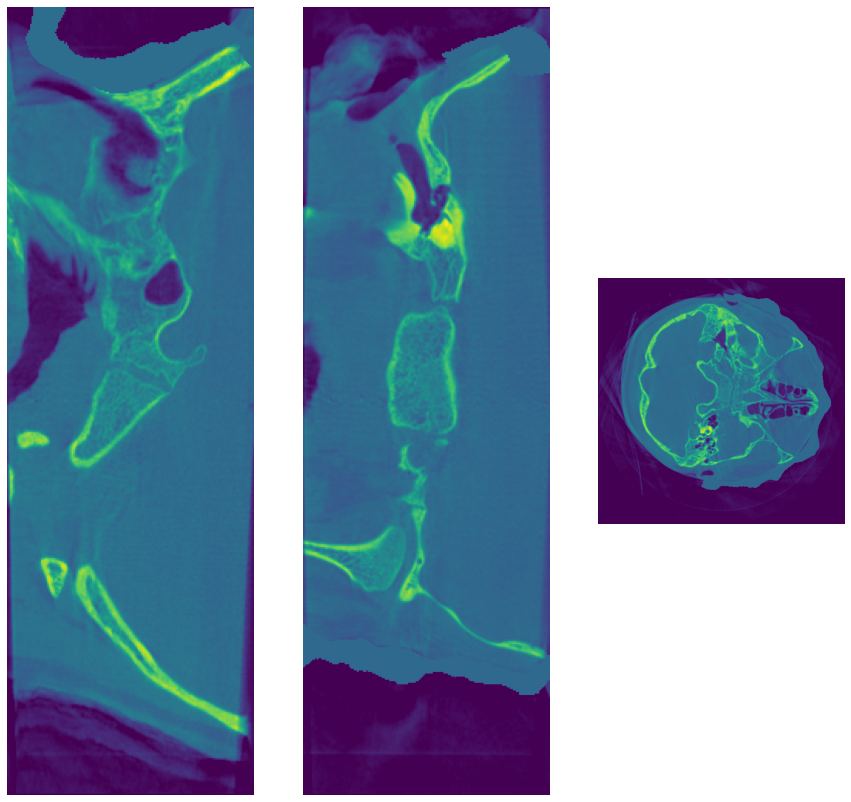

In [17]:
data_item = random.choice(data)
preview_image(monai.transforms.LoadImage(image_only=True)(data_item['img']), figsize=(15,15), normalize_by="slice")

In [7]:
data_seg_available = list(filter(lambda d: 'seg' in d.keys(), data))
data_seg_unavailable = list(filter(lambda d: 'seg' not in d.keys(), data))

data_seg_available_train, data_seg_available_valid = \
    monai.data.utils.partition_dataset(data_seg_available, ratios=(8, 2))

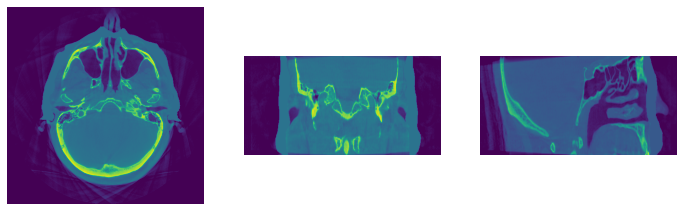

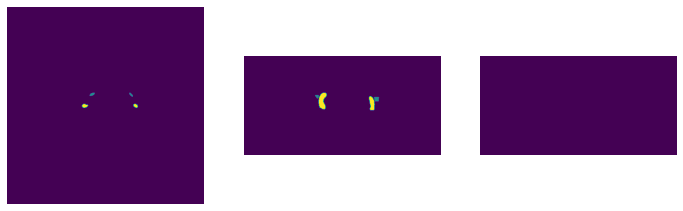

In [8]:
transform_seg_available = monai.transforms.Compose(
    transforms=[
        monai.transforms.LoadImageD(keys=['img', 'seg'], image_only=True),
        monai.transforms.TransposeD(keys=['img', 'seg'], indices=(2, 1, 0)),
        monai.transforms.AddChannelD(keys=['img', 'seg']),
        monai.transforms.SpacingD(keys=['img', 'seg'], pixdim=(1., 1., 1.), mode=('trilinear', 'nearest')),
        monai.transforms.OrientationD(keys=['img', 'seg'], axcodes='RAS'),
        monai.transforms.ResizeD(
            keys=['img', 'seg'],
            spatial_size=(256, 512, 512),
            mode=['trilinear', 'nearest'],
            align_corners=[False, None]
        ),
        monai.transforms.ToTensorD(keys=['img', 'seg'])
    ]
)
itk.ProcessObject.SetGlobalWarningDisplay(False)

#try:
  #preprocess_dir = os.path.join(data_dir, 'preprocess3')
  #os.mkdir(preprocess_dir)
#except:
  #print(f"{preprocess_dir} already exists!!!")

# Uncomment the following lines to preview a random image with the transform above applied
#for i in data_seg_available:
  #data_item = transform_seg_available(i)
  #name = os.path.basename(i['img']).split('.')[0]
  #img = nib.Nifti1Image(data_item['img'][0].detach().cpu().numpy(), affine = np.eye(4))
  #seg = nib.Nifti1Image(data_item['seg'][0].detach().cpu().numpy(), affine = np.eye(4))
  #nib.save(img, os.path.join(preprocess_dir, "test_" + name + ".nii.gz"))
  #nib.save(seg, os.path.join(preprocess_dir, "test_" + name + "_seg.nii.gz"))
data_item = transform_seg_available(random.choice(data_seg_available_train))
preview_image(data_item['img'][0], normalize_by='slice')
preview_image(data_item['seg'][0], normalize_by='slice')

In [9]:
dataset_seg_available_train = monai.data.CacheDataset(
    data=data_seg_available_train,
    transform=transform_seg_available,
    cache_num=16
)

dataset_seg_available_valid = monai.data.CacheDataset(
    data=data_seg_available_valid,
    transform=transform_seg_available,
    cache_num=16
)

Loading dataset: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


torch.Size([1, 256, 512, 512])


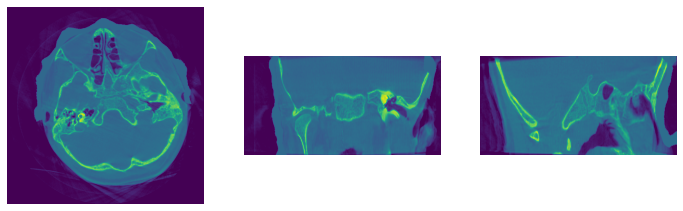

In [25]:
print(transform_seg_available(random.choice(data_seg_available_train))['img'].shape)
preview_image(transform_seg_available(random.choice(data_seg_available_train))['img'][0], normalize_by='slice')

In [15]:
# During the joint/alternating training process, we will use reuse data_seg_available_valid
# for validating the segmentation network.
# So we should not let the registration or segmentation networks see these images in training.
data_without_seg_valid = data_seg_unavailable + data_seg_available_train  # Note the order

# For validation of the registration network, we prefer not to use the precious data_seg_available_train,
# if that's possible. The following split tries to use data_seg_unavailable for the
# the validation set, to the extent possible.
data_valid, data_train = monai.data.utils.partition_dataset(
    data_without_seg_valid,  # Note the order
    ratios=(2, 8),  # Note the order
    shuffle=False
)


def take_data_pairs(data, symmetric=True):
    """Given a list of dicts that have keys for an image and maybe a segmentation,
    return a list of dicts corresponding to *pairs* of images and maybe segmentations.
    Pairs consisting of a repeated image are not included.
    If symmetric is set to True, then for each pair that is included, its reverse is also included"""
    data_pairs = []
    for i in range(len(data)):
        j_limit = len(data) if symmetric else i
        for j in range(j_limit):
            if j == i:
                continue
            d1 = data[i]
            d2 = data[j]
            pair = {
                'img1': d1['img'],
                'img2': d2['img']
            }
            if 'seg' in d1.keys():
                pair['seg1'] = d1['seg']
            if 'seg' in d2.keys():
                pair['seg2'] = d2['seg']
            data_pairs.append(pair)
    return data_pairs


data_pairs_valid = take_data_pairs(data_valid)
data_pairs_train = take_data_pairs(data_train)

In [16]:
def subdivide_list_of_data_pairs(data_pairs_list):
    out_dict = {'00': [], '01': [], '10': [], '11': []}
    for d in data_pairs_list:
        if 'seg1' in d.keys() and 'seg2' in d.keys():
            out_dict['11'].append(d)
        elif 'seg1' in d.keys():
            out_dict['10'].append(d)
        elif 'seg2' in d.keys():
            out_dict['01'].append(d)
        else:
            out_dict['00'].append(d)
    return out_dict


data_pairs_valid_subdivided = subdivide_list_of_data_pairs(data_pairs_valid)
data_pairs_train_subdivided = subdivide_list_of_data_pairs(data_pairs_train)

In [17]:
# print some useful counts to be aware of

num_train_reg_net = len(data_pairs_train)
num_valid_reg_net = len(data_pairs_valid)
num_train_both = len(data_pairs_train_subdivided['01']) +\
    len(data_pairs_train_subdivided['10']) +\
    len(data_pairs_train_subdivided['11'])


print(f"""We have {num_train_both} pairs to train reg_net and seg_net together,
  and an additional {num_train_reg_net - num_train_both} to train reg_net alone.""")
print(f"We have {num_valid_reg_net} pairs for reg_net validation.")

We have 296 pairs to train reg_net and seg_net together,
  and an additional 210 to train reg_net alone.
We have 30 pairs for reg_net validation.


## Test monai.transform 

In [46]:
a = monai.transforms.LoadImageD(keys=['img1', 'seg1', 'img2', 'seg2'], image_only=True, allow_missing_keys=True)
output = a(data_pairs_train_subdivided['00'][0])
print(output['img1'].shape)
print(output['img2'].shape)
b = monai.transforms.TransposeD(keys=['img1', 'seg1', 'img2', 'seg2'], indices=(2, 1, 0), allow_missing_keys=True)
output1 = b(output)
print(output1['img1'].shape)
print(output1['img2'].shape)
c = monai.transforms.AddChannelD(keys=['img1', 'seg1', 'img2', 'seg2'], allow_missing_keys=True)
output2 = c(output1)
print(output2['img1'].shape)
print(output2['img2'].shape)
d = monai.transforms.ResizeD(
    keys=['img1','seg1','img2', 'seg2'],
    spatial_size=(256, 512, 512),
    mode=['trilinear', 'nearest', 'trilinear', 'nearest'],
    allow_missing_keys=True,
    align_corners=[False, None, False, None]
)
output3 = d(output2)
print(output3['img1'].shape)
print(output3['img2'].shape)
e = monai.transforms.ConcatItemsD(keys=['img1', 'img2'], name='img12', dim=0)
output4 = e(output3)
print(output4['img12'].shape)

(512, 512, 199)
(512, 512, 303)
(199, 512, 512)
(303, 512, 512)
(1, 199, 512, 512)
(1, 303, 512, 512)
(1, 256, 512, 512)
(1, 256, 512, 512)
(2, 256, 512, 512)


In [18]:
transform_pair = monai.transforms.Compose(
    transforms=[
        monai.transforms.LoadImageD(keys=['img1', 'seg1', 'img2', 'seg2'], image_only=True, allow_missing_keys=True),
        monai.transforms.TransposeD(keys=['img1', 'seg1', 'img2', 'seg2'], indices=(2, 1, 0), allow_missing_keys=True),
        monai.transforms.ToTensorD(keys=['img1', 'seg1', 'img2', 'seg2'], allow_missing_keys=True), #if resize is not None else monai.transforms.Identity()
        monai.transforms.AddChannelD(keys=['img1', 'seg1', 'img2', 'seg2'], allow_missing_keys=True),
        monai.transforms.SpacingD(keys=['img1', 'seg1', 'img2', 'seg2'], pixdim=(1., 1., 1.), mode=('trilinear', 'nearest','trilinear', 'nearest'), allow_missing_keys=True),
        monai.transforms.OrientationD(keys=['img1', 'seg1', 'img2', 'seg2'], axcodes='RAS', allow_missing_keys=True),
        monai.transforms.ResizeD(
            keys=['img1','seg1','img2', 'seg2'],
            spatial_size=(256, 512, 512),
            mode=['trilinear', 'nearest', 'trilinear', 'nearest'],
            allow_missing_keys=True,
            align_corners=[False, None, False, None]
        ),
        monai.transforms.ConcatItemsD(keys=['img1', 'img2'], name='img12', dim=0),
        monai.transforms.DeleteItemsD(keys=['img1', 'img2']),
    ]
)
#print(transform_pair(data_pairs_valid_subdivided['00']))

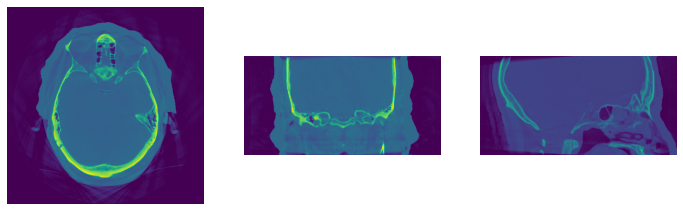

In [34]:
preview_image(transform_pair(data_pairs_valid_subdivided['00'][0])['img12'][0], normalize_by='slice')

In [19]:
dataset_pairs_train_subdivided = {
    seg_availability: monai.data.CacheDataset(
        data=data_list,
        transform=transform_pair,
        cache_num=32
    )
    for seg_availability, data_list in data_pairs_train_subdivided.items()
}


dataset_pairs_valid_subdivided = {
    seg_availability: monai.data.CacheDataset(
        data=data_list,
        transform=transform_pair,
        cache_num=32
    )
    for seg_availability, data_list in data_pairs_valid_subdivided.items()
}

Loading dataset:  78%|███████▊  | 25/32 [01:48<00:35,  5.06s/it]

: 

: 

## Define Network for Registration Model

We use a [MONAI UNet](https://docs.monai.io/en/stable/networks.html?highlight=unet#unet).

In [13]:
seg_net = monai.networks.nets.UNet(
    spatial_dims=3,  # spatial dims
    in_channels=1,  # input channels
    out_channels=4,  # output channels
    channels=(8, 16, 16, 32, 32, 64, 64),  # channel sequence
    strides=(1, 2, 1, 2, 1, 2),  # convolutional strides
    dropout=0.2,
    act='leakyrelu',
    norm='batch'
)
# Try out a forward pass

data_item = random.choice(dataset_seg_available_train)
seg_net_example_output = seg_net(data_item['img'].unsqueeze(0))
print(f"Segmentation classes: {torch.unique(data_item['seg'])}")
print(f"Shape of ground truth label: {data_item['seg'].unsqueeze(0).shape}")
print(f"Shape of seg_net output: {seg_net_example_output.shape}")

Segmentation classes: tensor([0., 1., 2., 3.])
Shape of ground truth label: torch.Size([1, 1, 256, 512, 512])
Shape of seg_net output: torch.Size([1, 4, 256, 512, 512])


## Define Network for Registration Model

In [ ]:
reg_net = monai.networks.nets.UNet(
    spatial_dims=3,  # spatial dims
    in_channels=2,  # input channels
    out_channels=3,  # output channels
    channels=(16, 32, 32, 32, 32),  # channel sequence
    strides=(1, 2, 2, 2),  # convolutional strides
    dropout=0.2,
    act='leakyrelu',
    norm='batch'
)
# Try out a forward pass
def take_random_from_subdivided_dataset(dataset_subdivided):
    """Given a dict mapping segmentation availability labels to datasets, return a random data item"""
    datasets = list(dataset_subdivided.values())
    datasets_combined = sum(datasets[1:], datasets[0])
    return random.choice(datasets_combined)


data_item = take_random_from_subdivided_dataset(dataset_pairs_train_subdivided)
reg_net_example_input = data_item['img12'].unsqueeze(0)
reg_net_example_output = reg_net(reg_net_example_input)
print(f"Shape of reg_net input: {reg_net_example_input.shape}")
print(f"Shape of reg_net output: {reg_net_example_output.shape}")